# Find the individuals most likely to donate to Charity ML

CharityML intends to solicit donations from prospective donors by sending letters via e-mails. The goal of the project is to find prospective donors who are most likely to donate towards the charity. 

In other words, the team needs to evaluate different machine learning models and identify the one that will yield the organization maximum amount of donations while minimizing the number of letters being sent out.

According to the results of an experiment done in the past by the organization, individuals who earned more than $50,000 are most likely to make a donation.

Therefore, our primary objective is to identify if the individual makes more than $50,000 or not.

## Table of Contents

## Get Data

Almost all libraries used in the notebook can be imported into the notebook. However, please pay special attention to the pandas_profiling package used for EDA which needs to be installed seperately.

If you are using Anaconda,you can install it using the following command:
conda install -c conda-forge pandas-profiling

or install it into the notebook using the following command:
pip install pandas-profiling

### 1. Libraries

In [99]:
# Basic Libraries
import pandas as pd
import pandas_profiling
import numpy as np
from time import time

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Performance Metrics
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Model Tuning
from sklearn.model_selection import GridSearchCV


# Visualization
import visuals as vs
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Display configuration
%matplotlib inline

### 2. Data

In [100]:
df_raw = pd.read_csv('./input/training.csv')

## Exploratory Data Analysis

### 1. Pre-cleansing exploratory data analysis

#### A. A snapshot of the raw dataframe

In [101]:
df_raw.head(3)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


2. The number of rows and columns in the data

#### B. Basic information on the dataframe

In [102]:
def column_data_types(df):
    
    # Operations
    n_records, n_features = df.shape
    data_types = df.dtypes.value_counts() 
    numeric_columns = df.select_dtypes([np.number]).columns.to_list()
    columns = list(df)
    categorical_columns = []
    
    for i in columns:
        if i not in numeric_columns:
            categorical_columns.append(i)
        else:
            None
    
    # Print results
    print('Number of rows:', n_records)
    print('Number of columns:', n_features)
    print('\n')
    print("Data types of columns:")
    print(data_types)
    print('\n')
    print('Categorical columns:',len(categorical_columns))
    print(categorical_columns)
    print('\n')
    print('Numeric columns:',len(numeric_columns))
    print(numeric_columns)
    

In [103]:
column_data_types(df_raw)

Number of rows: 45222
Number of columns: 14


Data types of columns:
object     9
float64    4
int64      1
dtype: int64


Categorical columns: 9
['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


Numeric columns: 5
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


#### C. Detailed EDA

Executing the following code will save the exploratory data analysis of the dataframe 'df_raw' in the same folder as the notebook.

In [104]:
profile = df_raw.profile_report(title='CharityML Pre-Cleansing Report')
profile.to_file(output_file="charityml_pre_cleansing_report.html")

#### D. Target Variable

In [105]:
def tatget_variable_analysis(column):
    
    # Operations
    summary = column.describe()
    unique_values = column.value_counts()
    percentage_missing_values = (column.count()/df_raw.shape[0])*100
    

    classes = column.unique().tolist()
    n_classes = len(classes)
    columns = n_classes + 1
    class_counts = column.value_counts().tolist()
    result = [[0] * columns for i in range(n_classes)]
    n_records = len(column)
    
    
    for i in range(n_classes):
        val_1 = classes[i]
        val_2 = class_counts[i]
        val_3 = round((val_2/n_records)*100,0)
        result[i][0] = val_1
        result[i][1] = val_2
        result[i][2] = val_3
    
    # Results
    print('Summary:')
    print(summary)
    print('\n')
    print('Unique values, their counts and percantage of rows:')
    for i in result:
        print(i)
    print('\n')
    print('% of valid rows:',percentage_missing_values)
    
    

In [106]:
target = df_raw['income']
tatget_variable_analysis(target)

Summary:
count     45222
unique        2
top       <=50K
freq      34014
Name: income, dtype: object


Unique values, their counts and percantage of rows:
['<=50K', 34014, 75.0]
['>50K', 11208, 25.0]


% of valid rows: 100.0


### 2. Conclusions

<u>General</u>

1. There are 13 features for us to work with for this project
2. The name of the target label is 'income'

<u>Data Preparation</u>:

1. There are no missing cells
2. We need to encode 9 columns
3. There are 5982 duplicate rows
4. Remove 34014 rows that contains data on individuals earning less than or equal to $50,000
5. There are five numeric columns, 

<u>Feature Wise</u>:

1. Zeros - capital-gain has 91.6% and capital-loss has 95.3% zeros

## 2. Data Preparation

### 1. Split dataframe to target and samples

In [107]:
#df_temp = df_raw[df_raw['income'] == '>50K']
y = df_raw['income']
X = df_raw.drop('income', axis=1)


### 2. Transform X

#### A. Transform skewed columns

/home/namita/Desktop/Charity ML/visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


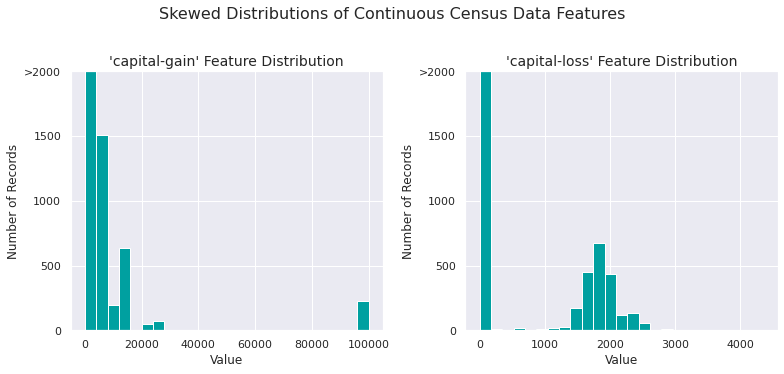

In [108]:
vs.distribution(X)

In [109]:
def transform_skwewed(X, skewed_col_list):
    skewed = skewed_col_list
    features_log_transformed = pd.DataFrame(data=X)
    features_log_transformed[skewed] = X[skewed].apply(lambda x: np.log(x + 1))
    return features_log_transformed

In [110]:
skewed_col_list = ['capital-gain', 'capital-loss']
df_prepared = transform_skwewed(X,skewed_col_list)

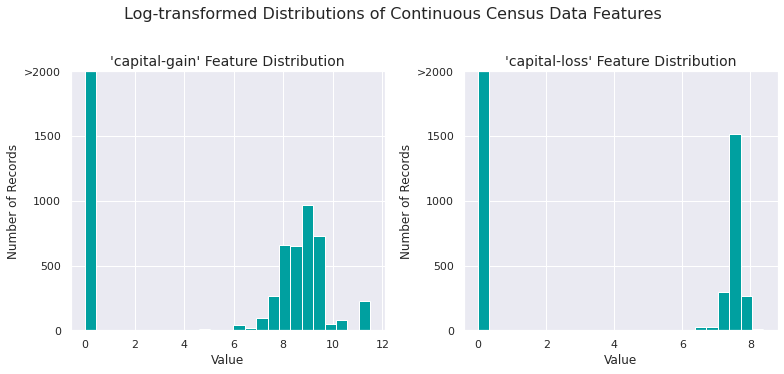

In [111]:
vs.distribution(df_prepared, transformed=True)

#### B. Normalize Numerical Features

In [112]:
scaler = MinMaxScaler()

In [113]:
def numeric_columns(df):
    
    # Operations
    n_records, n_features = df.shape
    data_types = df.dtypes.value_counts() 
    numeric_columns = df.select_dtypes([np.number]).columns.to_list()
    
    return numeric_columns


In [114]:
numerical_features = numeric_columns(df_prepared)

In [115]:
def numerical_column_transformation(df_prepared, numerical_features, scaler):
    features = pd.DataFrame(data=df_prepared)
    df_prepared[numerical_features] = scaler.fit_transform(features[numerical_features])
    return df_prepared
    

In [116]:
df_prepared = numerical_column_transformation(df_prepared, numerical_features, scaler)

In [117]:
display(df_prepared.head(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States


#### C. Encode non-numerical features and target label

In [118]:
def one_hot_encode(X, y):
    X = pd.get_dummies(X)
    y = pd.get_dummies(y)
    return X, y

In [119]:
def post_encoding_details(df):
    
    # Operations
    n_records = df.shape[0]
    n_features = df.shape[1]
    
    # Print results
    print('The number of records:', n_records)
    print('The number of features:', n_features)
    print('\n')
    return df.head(n=1)

In [120]:
df_prepared, y = one_hot_encode(df_prepared, y)

In [121]:
post_encoding_details(df_prepared)

The number of records: 45222
The number of features: 103




,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.30137,0.8,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [122]:
post_encoding_details(y)

The number of records: 45222
The number of features: 2




,<=50K,>50K
0,1,0


In [123]:
y = y['>50K']

**D. Correlation Analysis of prepared data**

In [158]:
def correlation_analysis(df, y):
    y.name = 'label'
    df_correlation = pd.concat((df_prepared,y), axis=1, join='inner')
    correlation_matrix = df_correlation.corr(method ='spearman')
    correlation_matrix = correlation_matrix['label']
    correlation_matrix = correlation_matrix.sort_values(ascending=False)
    correlation_matrix = correlation_matrix.iloc[1:]
    correlation_matrix = correlation_matrix.head(n=5)
    return correlation_matrix
    
    

In [159]:
correlation_analysis(df_prepared, y)

marital-status_ Married-civ-spouse    0.446192
relationship_ Husband                 0.403706
education-num                         0.328533
capital-gain                          0.277104
age                                   0.272185
Name: label, dtype: float64

#### E. Shuffle and split data

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [125]:
print('Number of records in training set:',X_train.shape[0])
print('Number of records in test set:',X_test.shape[0])

Number of records in training set: 36177
Number of records in test set: 9045


### 3. Conclusions

1. We are training our data on 36K records which has 103 features and testing on 9K records.
2. A step that is not mentioned in the notebook - if we filter the data by selecting individuals who make 50K above only, we get nly 102 features. Therefore there is at least one feature that correlates only to individuals who make atmost 50K a year.


## 3. Model Selection

### 1. Establish metrics

**Precision vs. Recall**

From the information provided, ChartiyML has strong evidence to suggest that only individuals who earns more than $50K will donate to the charity. 

Our positive class, 1 here is '>50K' and negative class 0 is '<=50K'. 

Every false positive result means sending out a letter that will not result in a donation. Therefore, precision is the measure that is important for us in this problem. 

What matters to more is that the number of true positives be accurate than the proprtion of true positives compared to all positives.

$$
Precision = [True Positives / (True Positives + False Positives)]
$$

$$
Recall = [True Positives / (True Positives + False Negatives)]
$$


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

When $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

**Metrics**

1. Accuracy 
2. Recall
3. Precision*

### 2. Naive Model

Class Balance - From the data, it is clear that 75% of our data is on negative class and 25% on positive class, which is skewed.

In the case of a naive model that sees only this data, if it gets a 100 points and predicts the class 1 all the time, it would be right 25% of the times.

When we consider our Naive model to predict a positive value all the time, there will be no negative predictions and hence no true negatives or false negatives

In [28]:
TP = np.sum(y) 
FP = y.shape[0] - TP 

TN = 0 
FN = 0 

beta = 0.5

# TODO: Calculate accuracy, precision and recall
accuracy = TP / y.shape[0]
recall = TP / (TP + FN)
precision = TP / (TP + FP)
    
multiplier = (1+beta**2)
numerator = precision * recall
denominator = (beta ** 2) * (precision + recall)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = multiplier * (numerator/denominator)


# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.9931]


### 3. Ensemble - Bagging

In [30]:
def model_performance(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    f_score = fbeta_score(y_test, predictions, beta=0.5)
    acc = accuracy_score(y_test, predictions, normalize=True)
    
    return f_score, acc

In [31]:
model_1 = RandomForestClassifier(n_jobs=-1)
f_score, accuracy = model_performance(model_1, X_train, X_test, y_train, y_test)
print("F-Score:", round(f_score,3))
print("Accuracy:", round(accuracy,3))

/home/namita/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F-Score: 0.674
Accuracy: 0.839


In [32]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    
    # Store time taken
    results = {}
    
    # Train the learner
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
    
    # Test the learner
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train, normalize=True)
    results['acc_test'] = accuracy_score(y_test, predictions_test, normalize=True)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    return results
    

/home/namita/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 3617 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 3617 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 3617 samples.


/home/namita/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/namita/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/namita/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/namita/Desktop/Charity ML/visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


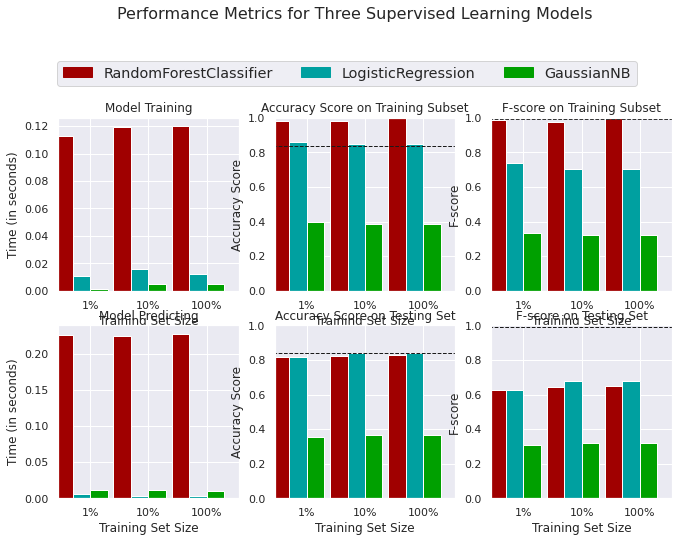

In [33]:
clf_A = RandomForestClassifier(n_jobs=-1)
clf_B = LogisticRegression()
clf_C = GaussianNB()

samples_100 = int(0.1*X_train.shape[0])
samples_10 = int(0.1*X_train.shape[0])
samples_1 = int(0.01*X_train.shape[0])


# Results on the learner
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

vs.evaluate(results, accuracy, fscore)




### 4. Model Tuning

#### A. Random Forest Classifier

In [ ]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = RandomForestClassifier(n_jobs=-1)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [20,40,80,100], 'min_samples_leaf': [1,2,3,5]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


/home/namita/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


### 3. Conclusions

### 4. Feature Importance

In [ ]:
model = RandomForestClassifier(n_jobs=-1)

importances = model.fit(X_train, y_train).feature_importances_

vs.feature_plot(importances, X_train, y_train)

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))